# Differential expression analysis
This notebook performs differential expression analysis using the real template experiment and simulated experiments, as a null set. 

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
num_runs = params['num_simulated']
project_id = params['project_id']
col_to_rank = params['col_to_rank']

rerun_template = False
rerun_simulated = False

In [4]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    project_id+"_groups.tsv")

## Install R libraries

In [5]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")
#BiocManager::install('EnhancedVolcano')
#devtools::install_github('kevinblighe/EnhancedVolcano')

NULL


In [6]:
%%R
library('limma')

### Get differentially expressed genes from template experiment

In [7]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir -i rerun_template

source('../functions/DE_analysis.R')

out_file <- paste(local_dir,
                  "DE_stats/DE_stats_template_data_",
                  project_id,
                  "_real.txt",
                  sep="")

if (rerun_template){
    get_DE_stats(metadata_file,
                 project_id, 
                 template_data_file,
                 "template",
                 local_dir,
                 "real")
    }

### Check signal strength

In [8]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

In [9]:
template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

template_DEGs = template_DE_stats[(template_DE_stats['adj.P.Val']<0.001) & 
                                  (template_DE_stats['logFC'].abs()>1)]
print(template_DEGs.shape)
template_DEGs.head(10)

(2358, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000234617.1,-4.958371,5.900715,-21.028533,2.622995e-16,3.059543e-12,26.913013
ENSG00000123243.14,-3.703407,3.134390,-20.765923,3.435758e-16,3.059543e-12,26.670781
ENSG00000149428.18,15.428655,22.573867,17.943078,7.722989e-15,4.584881e-11,23.824379
ENSG00000141448.8,-10.775702,9.814635,-17.440689,1.405587e-14,5.847755e-11,23.266538
ENSG00000235750.9,-16.443337,16.758748,-17.143822,2.016569e-14,5.847755e-11,22.928870
ENSG00000168994.13,-20.778738,22.482341,-17.102858,2.120448e-14,5.847755e-11,22.881796
ENSG00000077943.7,-7.371572,6.564904,-17.037318,2.298388e-14,5.847755e-11,22.806235
ENSG00000224660.1,-14.343534,17.211195,-16.570800,4.110789e-14,9.151645e-11,22.259542
ENSG00000135604.9,-23.845923,16.245391,-16.456649,4.749362e-14,9.398461e-11,22.123366
ENSG00000111450.13,-4.236599,6.620074,-16.277147,5.970376e-14,1.063324e-10,21.907272


In [10]:
%%R
library(EnhancedVolcano)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggrepel

  warnings.warn(x, RRuntimeWarning)


In [11]:
%%R -i project_id -i template_DE_stats_file -i local_dir

source('../functions/DE_analysis.R')

create_volcano(template_DE_stats_file,
               project_id,
               "adj.P.Val",
               local_dir)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


### Get differentially expressed genes from each simulated experiment

In [12]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -i rerun_simulated -o num_sign_DEGs_simulated

source('../functions/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    out_file <- paste(local_dir, 
                      "DE_stats/DE_stats_simulated_data_",
                      project_id,
                      "_",
                      i,
                      ".txt", 
                      sep="")
    
    if (rerun_simulated){
        run_output <- get_DE_stats(metadata_file,
                                   project_id, 
                                   simulated_data_file,
                                   "simulated",
                                   local_dir,
                                   i)
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
    } else {
        # Read in DE stats data
        DE_stats_data <- as.data.frame(read.table(out_file, sep="\t", header=TRUE, row.names=1))
        
        # Get number of genes that exceed threshold
        threshold <- 0.001
        sign_DEGs <- DE_stats_data[DE_stats_data[,'adj.P.Val']<threshold & abs(DE_stats_data[,'logFC'])>1,]
        
        num_sign_DEGs <- nrow(sign_DEGs)
        
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, num_sign_DEGs)
    }
}

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


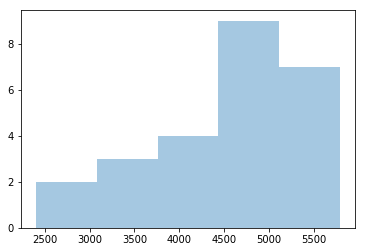

In [13]:
# Plot distribution of differentially expressed genes for simulated experiments
sns.distplot(num_sign_DEGs_simulated,
            kde=False)

**Check**

As a check, we compared the number of DEGs identified here versus what was reported in the [Kim et. al. publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/#pone.0055596.s008), which found:
* Four conditions needed to be met for the genes to be selected as differentially expressed genes (DEGs): (i) overall differential expression from the edgeR analysis with FDR < 0.001, (ii) a minimum of 3 patients with significant differential expression, as tested by edgeR for individual differential expression with FDR < 0.01, (iii) consistent up/down regulation among different patients representing more than a two-fold change, and (iv) significant expression in at least 3 patients to remove genes with large fold changes within the noise expression level (FVKM>2 in either normal or tumor tissue). 
* In total, we selected 1459 genes (543 upregulated and 916 downregulated in tumors) differentially expressed in female NSCLC never-smoker patients
* Used edgeR to identify DEGs

By comparison:
* Our study found 2358 DEGs using limma and applying FDR < 0.001 
* Spot checking the genes identified with their list of DEGs from S2, we found the some of the same genes and FC direction was consistent. 
* Currently we are normalizing read counts [downloaded from recount2](https://bioconductor.org/packages/devel/bioc/vignettes/recount/inst/doc/recount-quickstart.html) using RPKM and piping that through limma to identify DEG (this is legacy code from when we expected microarray input instead of RNA-seq)

## Get statistics for differential expression analysis

In [14]:
# Get ranks of template experiment

# If ranking by p-value or adjusted p-value then high rank = low value
if col_to_rank in ['P.Value', 'adj.P.Val']:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].rank(ascending = False)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=True)

# If ranking by logFC then high rank = high abs(value)
elif col_to_rank in ['logFC','t']:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].abs().rank(ascending = True)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=False)

# If ranking by Z-score then high rank = high value
else:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].rank(ascending = True)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=False)

template_DE_stats.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking
ENSG00000211896.7,4217.285092,2847.658556,2.673370,0.013712,0.034456,-3.806048,17809.0
ENSG00000161055.3,2953.135576,1565.924672,2.016723,0.055791,0.107397,-5.082555,17807.0
ENSG00000086548.8,682.863735,420.210228,4.225260,0.000333,0.001751,-0.225240,17806.0
ENSG00000254709.7,605.225857,482.844988,3.305837,0.003145,0.010628,-2.410281,17804.0
ENSG00000108821.13,372.527241,283.027840,2.744168,0.011684,0.030392,-3.656524,17798.0


In [15]:
# Concatenate simulated experiments
simulated_DE_stats_all = pd.DataFrame()
for i in range(num_runs):
    simulated_DE_stats_file = os.path.join(
        local_dir, 
        "DE_stats",
        "DE_stats_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    #Read results
    simulated_DE_stats = pd.read_csv(
        simulated_DE_stats_file,
        header=0,
        sep='\t',
        index_col=0)
    
    simulated_DE_stats.reset_index(inplace=True)
    
    # Concatenate df
    simulated_DE_stats_all = pd.concat([simulated_DE_stats_all,
                                       simulated_DE_stats])
    
print(simulated_DE_stats_all.shape)
simulated_DE_stats_all.head()

(445250, 7)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,ENSG00000167703.14,-2.594250,5.886292,-36.501319,1.155545e-21,2.034972e-17,39.353142
1,ENSG00000169871.12,-2.339417,9.085292,-35.403447,2.285201e-21,2.034972e-17,38.723706
2,ENSG00000003402.19,-3.710083,7.897625,-31.625781,2.820143e-20,1.358379e-16,36.369091
3,ENSG00000135604.9,-7.303417,7.965458,-31.271466,3.622192e-20,1.358379e-16,36.131792
4,ENSG00000087266.15,-1.871000,7.077917,-31.178783,3.869009e-20,1.358379e-16,36.069216


In [16]:
# Aggregate statistics across all simulated experiments
if col_to_rank == "adj.P.Val":
    simulated_DE_summary_stats = simulated_DE_stats_all.groupby(['index'])[[col_to_rank]].agg(
        ['median','mean', 'std','count']
    )
else:
    simulated_DE_summary_stats = simulated_DE_stats_all.groupby(['index'])[[col_to_rank, 'adj.P.Val']].agg({
        col_to_rank:['median','mean', 'std','count'],
        'adj.P.Val':['median']
    })
simulated_DE_summary_stats.head()

logFC                           adj.P.Val
                      median      mean       std count    median
index                                                           
ENSG00000000003.14  1.484167  1.273367  2.405019    25  0.000090
ENSG00000000005.5  -0.048333 -0.073860  0.092570    25  0.006650
ENSG00000000419.12  6.351000  6.086243  2.848614    25  0.000078
ENSG00000000457.13  0.424417  0.530620  0.406266    25  0.000526
ENSG00000000460.16  0.592250  0.428900  0.485009    25  0.000021

In [17]:
# Rank gene by median value of col_to_rank for simulated experiments

# If ranking by p-value or adjusted p-value then high rank = low value
if col_to_rank in ['P.Value', 'adj.P.Val']:
    simulated_DE_summary_stats['ranking'] = simulated_DE_summary_stats[(col_to_rank,'median')].rank(ascending = False)
    simulated_DE_summary_stats = simulated_DE_summary_stats.sort_values(by=(col_to_rank,'median'), ascending=True)

# If ranking by logFC then high rank = high abs(value)
elif col_to_rank in ['logFC','t']:
    simulated_DE_summary_stats['ranking'] = simulated_DE_summary_stats[(col_to_rank,'median')].abs().rank(ascending = True)
    simulated_DE_summary_stats = simulated_DE_summary_stats.sort_values(by=(col_to_rank,'median'), ascending=False)

# If ranking by Z-score then high rank = high value
else:
    simulated_DE_summary_stats['ranking'] = simulated_DE_summary_stats[(col_to_rank,'median')].rank(ascending = True)
    simulated_DE_summary_stats = simulated_DE_summary_stats.sort_values(by=(col_to_rank,'median'), ascending=False)

simulated_DE_summary_stats.head()

logFC                                   adj.P.Val  \
                        median        mean         std count        median   
index                                                                        
ENSG00000161016.16  135.332167  133.346643   82.021258    25  2.834129e-07   
ENSG00000111640.14  133.406250  110.571827  165.924097    25  7.053722e-05   
ENSG00000171345.13  100.954667  175.930760  283.570266    25  1.035334e-05   
ENSG00000211896.7    97.326667  241.249243  292.112986    25  2.797092e-03   
ENSG00000074800.13   78.674917   77.671803   73.237833    25  3.079616e-07   

                    ranking  
                             
index                        
ENSG00000161016.16  17803.0  
ENSG00000111640.14  17802.0  
ENSG00000171345.13  17797.0  
ENSG00000211896.7   17796.0  
ENSG00000074800.13  17792.0

In [18]:
simulated_DE_summary_stats.tail()

logFC                                   adj.P.Val  \
                        median        mean         std count        median   
index                                                                        
ENSG00000205542.10 -178.173833 -247.481927  402.201548    25  2.014736e-03   
ENSG00000167996.15 -190.400500 -288.569740  338.622451    25  1.877990e-03   
ENSG00000034510.5  -193.798750 -226.265863  235.994133    25  2.154298e-02   
ENSG00000204592.8  -228.492083 -224.650727  147.655537    25  5.622007e-10   
ENSG00000087086.14 -533.445583 -518.697480  490.821087    25  8.990430e-04   

                    ranking  
                             
index                        
ENSG00000205542.10  17806.0  
ENSG00000167996.15  17807.0  
ENSG00000034510.5   17808.0  
ENSG00000204592.8   17809.0  
ENSG00000087086.14  17810.0

In [19]:
# Merge template statistics with simulated statistics
template_simulated_DE_stats = template_DE_stats.merge(simulated_DE_summary_stats, 
                                                     left_index=True,
                                                     right_index=True)
print(template_simulated_DE_stats.shape)
template_simulated_DE_stats.head()

(17810, 13)


/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking,"(logFC, median)","(logFC, mean)","(logFC, std)","(logFC, count)","(adj.P.Val, median)","(ranking, )"
ENSG00000211896.7,4217.285092,2847.658556,2.673370,0.013712,0.034456,-3.806048,17809.0,97.326667,241.249243,292.112986,25,0.002797,17796.0
ENSG00000161055.3,2953.135576,1565.924672,2.016723,0.055791,0.107397,-5.082555,17807.0,22.571833,85.646027,145.960754,25,0.040149,17678.0
ENSG00000086548.8,682.863735,420.210228,4.225260,0.000333,0.001751,-0.225240,17806.0,44.258833,81.228950,93.153531,25,0.000756,17768.0
ENSG00000254709.7,605.225857,482.844988,3.305837,0.003145,0.010628,-2.410281,17804.0,6.118500,38.429430,88.160462,25,0.004840,17068.0
ENSG00000108821.13,372.527241,283.027840,2.744168,0.011684,0.030392,-3.656524,17798.0,-16.058833,-25.240620,45.499063,25,0.000918,17586.0


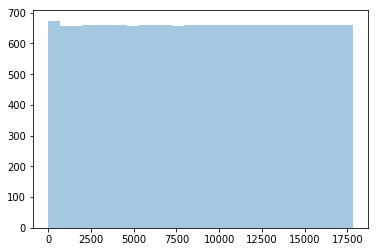

In [20]:
sns.distplot(template_simulated_DE_stats[('ranking',"")].values, kde=False)

In [21]:
# Parse columns
median_pval_simulated = template_simulated_DE_stats[('adj.P.Val','median')]
mean_test_simulated = template_simulated_DE_stats[(col_to_rank,'mean')]
std_test_simulated = template_simulated_DE_stats[(col_to_rank,'std')]
count_simulated = template_simulated_DE_stats[(col_to_rank,'count')]
rank_simulated = template_simulated_DE_stats[('ranking','')]

In [22]:
summary = pd.DataFrame(data={'Gene ID': template_simulated_DE_stats.index,
                             'Adj P-value (Real)': template_simulated_DE_stats['adj.P.Val'],
                             'Rank (Real)': template_simulated_DE_stats['ranking'],
                             'Test statistic (Real)': template_simulated_DE_stats[col_to_rank],
                             'Median adj p-value (simulated)': median_pval_simulated ,
                             'Rank (simulated)': rank_simulated ,
                             'Mean test statistic (simulated)': mean_test_simulated ,
                             'Std deviation (simulated)': std_test_simulated,
                             'Number of experiments (simulated)': count_simulated
                            }
                      )
summary['Z score'] = (summary['Test statistic (Real)'] - summary['Mean test statistic (simulated)'])/summary['Std deviation (simulated)']
summary.head()

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
ENSG00000211896.7,ENSG00000211896.7,0.034456,17809.0,4217.285092,0.002797,17796.0,241.249243,292.112986,25,13.611294
ENSG00000161055.3,ENSG00000161055.3,0.107397,17807.0,2953.135576,0.040149,17678.0,85.646027,145.960754,25,19.645620
ENSG00000086548.8,ENSG00000086548.8,0.001751,17806.0,682.863735,0.000756,17768.0,81.228950,93.153531,25,6.458529
ENSG00000254709.7,ENSG00000254709.7,0.010628,17804.0,605.225857,0.004840,17068.0,38.429430,88.160462,25,6.429145
ENSG00000108821.13,ENSG00000108821.13,0.030392,17798.0,372.527241,0.000918,17586.0,-25.240620,45.499063,25,8.742331


In [23]:
# Save file
summary_file = os.path.join(
        local_dir, 
        "gene_summary_table_"+col_to_rank+".tsv")

summary.to_csv(summary_file, float_format='%.5f', sep='\t')